In [189]:
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from shapely import Polygon, intersection, union
from skimage.measure import find_contours

In [ ]:
image = cv2.imread("../tattoo_images/2776427893_58405d2a94.jpg")
#cv2.rectangle(image,)
cv2.imshow("first_tatto",image)
cv2.waitKey(10)
cv2.destroyAllWindows()

In [ ]:
annotation_file = "../tattoo_annotations.txt"
annotations = []
match_pattern =r'(.+\.jpg) (\[.+\])'
split_pattern = r'[;\s\t\n\]]'
result = {}
with open(annotation_file) as file:
    for input_str in file.readlines():
        match = re.match(match_pattern, input_str)
        if match:
            filename = match.group(1)
            coordinates_str = match.group(2)
            coordinates_list = re.split(split_pattern, coordinates_str)
            coordinates_list = [x.strip(r"\[\]") for x in coordinates_list if x != ""]
            result[filename] = coordinates_list
        else:
            print("No matches!")

In [ ]:
results_evaluated = {}
for k,v in result.items():
    results_evaluated[k] = [eval(x) for x in v]


In [ ]:
points = results_evaluated["2776427893_58405d2a94.jpg"]
points = [tuple(int(value) for value in original_tuple) for original_tuple in points]
for point in points:
    cv2.polylines(image, [np.array(points)], isClosed=False, color=(0, 255, 0), thickness=2)
cv2.imshow("Image with points", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["default"](checkpoint="D:/Documents/AAA_Hochschule/SoSe_24/Biometrics/sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
for m in masks:
    print(m["segmentation"][350])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mask_to_image(image, mask):
    """
    Apply binary mask to the image and set False areas to black.

    Args:
    image (numpy.ndarray): The original image.
    mask (numpy.ndarray): Binary mask indicating areas to keep.

    Returns:
    numpy.ndarray: Processed image.
    """
    # Copy the original image to avoid modifying it directly
    processed_image = np.copy(image)

    # Set False areas to black
    processed_image[~mask] = 0

    return processed_image

# Example usage:
# Assuming you have your binary mask as 'binary_mask' and your original image as 'original_image'
# Create some sample data for demonstration
binary_mask = np.random.choice([True, False], size=(100, 100))

# Convert binary mask to image
processed_image = mask_to_image(image,masks[0]['segmentation'])

# Display original and processed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')
plt.show()



In [ ]:
processed_image = mask_to_image(image,masks[1]['segmentation'])

# Display original and processed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')

plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mask_to_image(image, mask):
    """
    Apply binary mask to the image and set False areas to black.

    Args:
    image (numpy.ndarray): The original image.
    mask (numpy.ndarray): Binary mask indicating areas to keep.

    Returns:
    numpy.ndarray: Processed image.
    """
    # Copy the original image to avoid modifying it directly
    processed_image = np.copy(image)

    # Set False areas to black
    processed_image[~mask] = 0

    return processed_image

def plot_segmentations(original_image, segmentations, titles):
    """
    Plot the original image along with multiple segmented images.

    Args:
    original_image (numpy.ndarray): The original image.
    segmentations (list of numpy.ndarray): List of segmented images.
    titles (list of str): Titles for each segmented image.
    """
    num_segmentations = len(segmentations)
    num_plots = num_segmentations + 1  # Include original image

    plt.figure(figsize=(5 * num_plots, 5))

    # Plot the original image
    plt.subplot(1, num_plots, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot each segmented image
    for i in range(num_segmentations):
        plt.subplot(1, num_plots, i + 2)
        plt.imshow(segmentations[i], cmap="grey")
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

# Example usage:
# Assuming you have your original image as 'original_image' and a list of binary masks as 'segmentation_masks'
# Also assuming you have a list of titles for each segmentation mask as 'segment_titles'

# Create some sample data for demonstration
num_segmentations = len(masks)
segment_titles = [f'Segmentation {i+1}' for i in range(num_segmentations)]

# Convert binary masks to images
segmented_images = [mask['segmentation'] for mask in masks]

# Plot original image and segmented images
plot_segmentations(image, segmented_images, segment_titles)


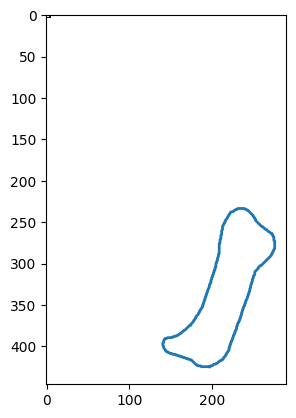

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


# Find contours
contours = find_contours(masks[1]["segmentation"], 0.5)

# Plot the binary mask
plt.imshow(binary_mask, cmap='gray')

# Plot each contour as a polygon
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.axis('image')
plt.show()


In [160]:
contours[0]

array([[471. , 217.5],
       [470. , 217.5],
       [469.5, 218. ],
       ...,
       [471.5, 216. ],
       [471.5, 217. ],
       [471. , 217.5]])

In [196]:
def calculate_iou(polygon1, polygon2):
    polygon1 = Polygon(polygon1)
    polygon2 = Polygon(polygon2)

    intersection_area = intersection(polygon1, polygon2).area
    union_area = union(polygon1, polygon2).area

    IOU = intersection_area/union_area

    return IOU
for mask in masks:
    contours = find_contours(mask["segmentation"], 0.5)
    if len(contours) > 1:
        print(len(contours))
        print("No")
    else:
        print(calculate_iou(points, contours[0]))


5
No
0.022931095578158252
0.0
0.0
0.01094088660813381
0.0
0.0
0.0
0.0
0.0
0.0
0.005487085274901756
0.0
0.0


In [195]:

p2 = Polygon(points)

p1 = Polygon(contours[0])
(intersection(p1,p2).area)/(union(p1,p2).area)

0.022931095578158252